In [1]:
%matplotlib inline
import math
from types import SimpleNamespace
import numpy as np
import sympy
from sympy import Symbol, solve
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from copy import deepcopy as DC
sympy.init_printing()

# Conventions
Origin: On the ground below plane at $t_0$.

X axis [0]: 90 degrees clockwise of Y axis.

Y axis [1]: Direction of helicopter.

Z axis [2]: Pointed up vertically.

Absolute velocity (for determining position) is with respect to the ground.

East: 0 degrees, i.e. direction of positive X axis.

North: 90 degrees, i.e. direction of positive Y axis.

# Assumptions
* The system is released at a fixed height.
    * It is relatively trivial to make this vary.
* The system exits the helicopter at a right angle with a small velocity.
* The wind is 3.1 m/s in some direction.
* The helicopter is traveling at 18 m/s directly against the wind.
* The static line is about 2 m long and the system only drops straight down until it becomes taut.
    * It would be trivial to use our quartic function to negate the assumption of it dropping straight down.
* Deployment timer and actuation of eNSR ring takes 2 s.
* Drag doesn't take effect until the drogue line goes taut.
    * We could change this if some brave soul figures out the Cd and front area of the undeployed system.
* The lines connecting the drogue chute to the 50 ft shock cord are negligible.
* The drogue pulls out at an angle, i.e. hold the drogue at the point of deployment and use Pythagorean theorem with shock cord as hypotenuse following trajectory.
* When line becomes taut, drogue effects drag forces instantaneously.
* When main chute deploys, it instantly takes effect on drag.
* The terrain is flat and free of objects.

# Variables
Coming soon to a theater near you

# SOP
You can modify assumptions on the fly in this document. It runs a sim with default values and graphs it automatically. Keep in mind that you can use main() with its arguments to specify some of the variables of the model, but some variables are hardcoded as parameters. Also remember that this tool has been broken into many functions for a reason. Up next we will import it as a library in another document and run many different sims to compare, so it has been coded with that in mind.

### Facts

In [2]:
# g = acceleration due to gravity [kg*m/s^2]
g = -9.80665
# density of air [kg/m^3]
rho = 1.2 # rough estimate

# simulation timestep [s]
time_step = 0.05 # this is fine, it even works with 0.25. It breaks if you go much above that.
epsilon = 10**(-10) # just in case we want to jump to terminal velocity if we get close enough

### Physical Parameters
120in. Rocketman High Performance CD 2.2 Parachute

https://the-rocketman.com/high-performance-parachutes/

I'm not sure which of these drogue descent rates should be used, but we'll pick one arbitrarily until we get better info.

https://web.archive.org/web/20181110101551/http://the-rocketman.com/drogue-decent-rate.html

https://the-rocketman.com/pro-x/

This is another potential source for Main Chute characteristics, but the above ones should be correct.

https://web.archive.org/web/20181106062354/http://www.the-rocketman.com/decent-rate.html

In [3]:
# mass of payload [kg]
m = 30. # needs a sanity check but this determines almost everything to follow
drop_height = 609.6 # [m] (2000 ft)

# static line length [m]
sl = 2.
# drogue deployment timer [s]
d_deploy_t = 4.

# radius of drogue [m]
r_d = 0.762
# drogue line length [m]
dl = 50. * 0.3048 # note that it is ambiguous whether this should be 50 feet or meters. I assume feet, then convert
# terminal velocity of drogue [m/s]
vt_d = -18.5 # extremely rough eyeball estimate from rocketman

# main chute deployment timer [s]
c_deploy_t = 10.

# radius of main chute [m]
r_c = 3.048 / 2 # [m] (120 in diameter)
# drag coefficients of main chute [m/s]
C_d_c = 2.2 # from rocketman, or your money back

C_d_dud = 0.3 # this is entirely an arbitrary guess. kinda close to a car, kinda close to lv4
A_dud = np.pi* 0.127**2 # [m] (5 in radius) i pulled this number out of a hat but we could probably just measure it

# the three below values aren't used
# i am suspicious of which values to use so I have them all here and we can pick the reasonable ones later
#vt_c_old_2 = -5.1816 # taken from newer rocketman table
#vt_c_old = -6.352 # extremely rough estimate from old rocketman table
#C_d_drogue = 0.97 # taken from rocketman, not sure if applicable

### Preliminary Calculations
Source [http://www.pcprg.com/rocketre.htm]

In [4]:
weight = abs(m * g) # drag force at terminal velocity [N]

A_d = np.pi * r_d**2 # frontal area of drogue [m^2]
C_d_d = (2 * weight) / (rho * A_d * vt_d**2) # drag coeff. of drogue []

A_c = np.pi * r_c**2 # frontal area of main chute [m^2]

def term_vel(C_d, A):
    return -np.sqrt(2* weight/(C_d * rho *A))

vt_c = term_vel(C_d_c, A_c)

# safety distance above the ground that the main chute should deploy at [m]
safety_dist= 304.8 # = 1000 ft # DEPRECATED
# time until ground impact from safety distance at main chute's terminal velocity
chute_t = abs(safety_dist / vt_c) # DEPRECATED

### Functions

In [5]:
# calculates drag in all directions
# note that i am assuming that drag splits up in all dimensions equally
# idk if i should be assuming something about laminar flow in horizontal plane
# because i just learned what that even was
def drag_forces(v, C_d, A):
    norm = np.linalg.norm(v)
    return (-A/2 * C_d * rho * norm) * v

# solve a quartic to find the time at which the drogue chute becomes taut
# i'll make the names more iconic later, for now its fine
# at some point i'll do some actual math and make sure this can only return one positive real instead of assuming
def quartic(v_now):
    Ps, vds, gs, Lvds, Lhds, tds, vcs, side = sympy.symbols('Ps vds gs Lvds Lhds tds vcs side')
    Dparms = {side: v_now[0], Ps: v_now[1], vcs: v_now[2], gs: g}
    tdEqn = (side*tds)**2 + (Ps*tds)**2 + (vcs*tds + 0.5*gs*tds**2)**2 - dl**2
    tdSolns = sympy.solve(tdEqn.subs(Dparms))
    for soln in [complex(x) for x in tdSolns]:
        if (soln.imag > epsilon) or (soln.real <= 0):
        #if (soln.imag != 0) or (soln.real <= 0):
            pass
        else:
            td = soln.real
    return td

# func for integrating. dis our ODE
# i know it's kinda weird to put logic inside an ode but it made sense at the time
def ode_f(x, v, t, phs, st8, v_w):
    if phs['live']: # drogue or chute active
        if phs['steadystate']: # aerodynamic equilibrium
            rel_v = np.zeros(3)
            abs_v = DC(v_w)
            rel_v[2], abs_v[2] = (vt_c, vt_c) if phs['mainchute'] else (vt_d, vt_d)
        else:
            rel_v = v - v_w
            abs_v = v
        # remember that drag depends on velocity of object relative to medium
        D = drag_forces(rel_v, st8[0], st8[1]) / m
    elif not phs['live']:
        rel_v = v - v_w
        D = drag_forces(rel_v, C_d_dud, A_dud) / m # took a stab at guessing dud parameters, plz sanitize eventually
        abs_v = v
    a = D + np.array([0, 0, g])
    return np.array([abs_v, a])

# runge kutta integrator
def runge_kutta(sim, next_step):
    dt = sim.dt
    k1 = ode_f(sim.x[-1],
            sim.v[-1],
            sim.t[-1],
            sim.phase,
            sim.state,
            sim.v_w)
    k2 = ode_f(sim.x[-1] + k1[0] * dt/2,
            sim.v[-1] + k1[1] * dt/2,
            sim.t[-1] + dt/2,
            sim.phase,
            sim.state,
            sim.v_w)
    k3 = ode_f(sim.x[-1] + k2[0] * dt/2,
            sim.v[-1] + k2[1] * dt/2,
            sim.t[-1] + dt/2,
            sim.phase,
            sim.state,
            sim.v_w)
    k4 = ode_f(sim.x[-1] + k3[0] * dt,
            sim.v[-1] + k3[1] * dt,
            sim.t[-1] + dt,
            sim.phase,
            sim.state,
            sim.v_w)
    next_step.x = sim.x[-1] + dt * (k1[0] + 2*k2[0] + 2*k3[0] + k4[0]) / 6
    next_step.v = sim.v[-1] + dt * (k1[1] + 2*k2[1] + 2*k3[1] + k4[1]) / 6
    next_step.t = sim.t[-1] + dt
    next_step.a = (k1[1] + 2*k2[1] + 2*k3[1] + k4[1]) / 6

# keep eyebleed hidden
def update(sim, next_step):
    sim.x = np.append(sim.x, [next_step.x], axis=0)
    sim.v = np.append(sim.v, [next_step.v], axis=0)
    sim.t = np.append(sim.t, next_step.t)
    sim.a = np.append(sim.a, [next_step.a], axis=0)

# this is gonna get called during each phase for some amout of time
def iterate(sim, next_step, time):
    start = sim.t[-1] # offset
    # pretttttyy logic
    while (not sim.phase['mainchute'] and sim.t[-1] < start+time) or (sim.phase['mainchute'] and sim.x[-1][2] > 0):
        runge_kutta(sim, next_step)
        update(sim, next_step)
        if sim.x[-1][2] <= 0: break # kind of a kludge in case drogue fails and we impact before main deploys

        if sim.assume_limit: # in case we want to check whether we're close to terminal velocity
            terminal = vt_c if sim.phase['mainchute'] else vt_d
            if abs(next_step.v[2] - terminal) < epsilon: sim.phase['steadystate'] = True # jump to steady state

# no interesting code in this func, just graphing stuff
def graph_sol(sim, start=0, end=None):
    # break out the solutions into convenient names:
    time = sim.t[start:end]
    soln_d_x = [s[0] for s in sim.x][start:end]
    soln_d_y = [s[1] for s in sim.x][start:end]
    soln_d_z = [s[2] for s in sim.x][start:end]
    soln_d_xdot = [s[0] for s in sim.v][start:end]
    soln_d_ydot = [s[1] for s in sim.v][start:end]
    soln_d_zdot = [s[2] for s in sim.v][start:end]
    soln_d_xddot = np.diff(soln_d_xdot) # x acceleration
    soln_d_yddot = np.diff(soln_d_ydot) # y acceleration
    soln_d_zddot = np.diff(soln_d_zdot) # z acceleration
    
    # plot da shiz:
    plt.figure(1)
    plt.plot(soln_d_y, soln_d_z)
    plt.axis('equal')
    plt.grid()
    plt.title('down-range trajectory')
    plt.xlabel('horizontal range (m)')
    plt.ylabel('vertical range (m)')
    
    plt.figure(2)
    plt.plot(time, soln_d_ydot)
    plt.xlabel('time (s)')
    plt.ylabel('horizontal velocity (m/s)')
    
    plt.figure(3)
    plt.plot(time, soln_d_zdot)
    plt.xlabel('time (s)')
    plt.ylabel('vertical velocity (m/s)')
    
    plt.figure(4)
    plt.plot(time[:-1], soln_d_yddot)
    plt.xlabel('time (s)')
    plt.ylabel('horizontal acceleration (m/s^2)')

    plt.figure(5)
    plt.plot(time[:-1], soln_d_zddot)
    plt.xlabel('time (s)')
    plt.ylabel('vertical acceleration (m/s^2)')
    
    plt.figure(6)
    plt.plot(sim.x[0][0], sim.x[0][1],'r^')
    plt.plot(sim.x[-1][0], sim.x[-1][1],'bs')
    plt.xlabel('First and Last X pos')
    plt.ylabel('First and Last Y pos')
    plt.grid()
    plt.axis('equal')
    
    plt.figure(7)
    plt.plot(soln_d_y, soln_d_ydot)
    plt.xlabel('horizontal range (m)')
    plt.ylabel('horizontal velocity (m/s)')
    
    plt.figure(8)
    plt.plot(soln_d_ydot[:-1], soln_d_yddot)
    plt.xlabel('horizontal velocity (m/s)')
    plt.ylabel('horizontal acceleration (m/s^2)')
    
    plt.figure(9)
    plt.plot(sim.t, sim.a)
    plt.xlabel('time (s)')
    plt.ylabel('acceleration (m/s^2)')
    plt.legend(['x', 'y', 'z'])

### Flight plan

No Failures detected!

Static Line Taut!

Drogue Deployed!

Drogue Line Taut!

Drogue Actively Dragging!

Main Chute Actively Dragging!

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 211.8 m = 694.89 ft
TOTAL VERTICAL DISTANCE DESCENDED: 609.61 m = 2000.05 ft
TOTAL TIME FOR DESCENT: 66.52 s = 1.11 min
Final coordinates: (x, y) = ( -3.7033400964935815e-14 , -211.80267044263724 )


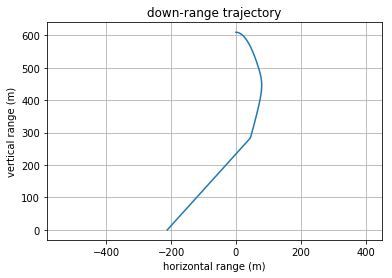

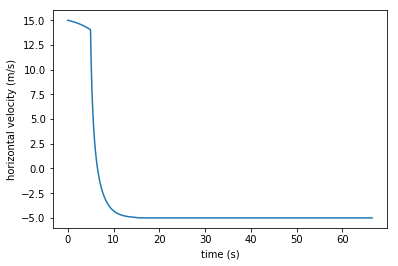

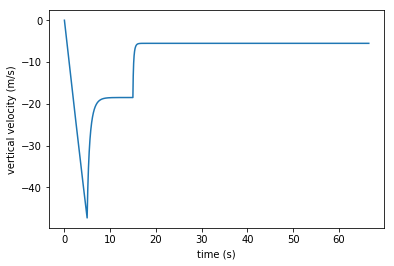

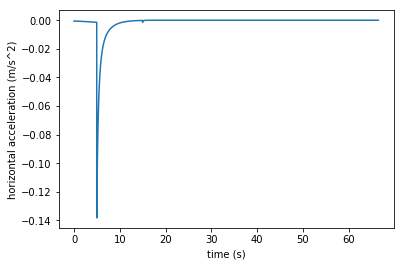

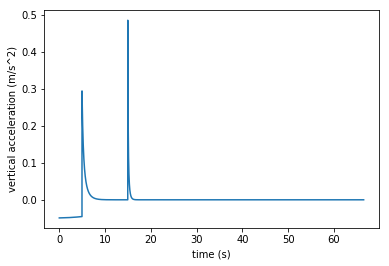

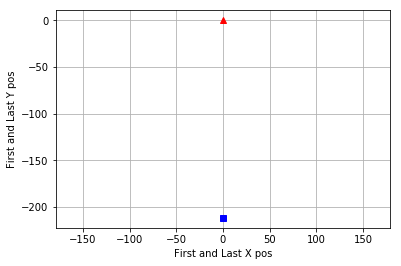

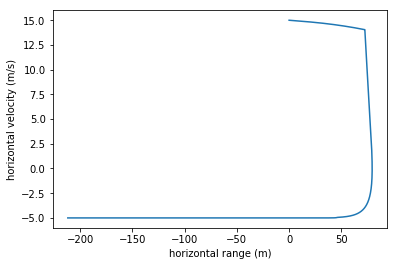

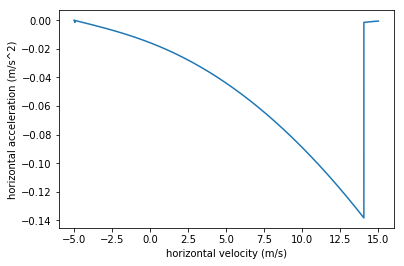

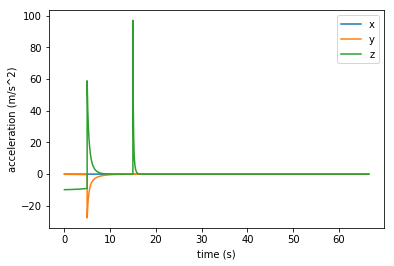

In [6]:
phase = {'live': False, 'steadystate': False, 'mainchute': False}
fail_mode = {'drogue': False, 'mainchute': False, 'early': False}

def set_failure_mode(sim, mode):
    sim.fail_mode = DC(fail_mode)
    if mode == 'A':
        sim.fail_mode['mainchute'] = True
        if sim.prnt: print('Main Chute Failure!\n')
    elif mode == 'B':
        sim.fail_mode['drogue'] = True
        if sim.prnt: print('Drogue Failure!\n')
    elif mode == 'C':
        sim.fail_mode['drogue'] = True
        sim.fail_mode['early'] = True
        if sim.prnt: print('Drogue Failure and Early Main Chute Deployment!\n')
    elif mode == 'D': # d is for dud, it's good enough for me
        sim.fail_mode['mainchute'] = True
        sim.fail_mode['drogue'] = True
        if sim.prnt: print('Recovery system is a dud! Now Im freee. Free fallin!\n')
    else:
        if sim.prnt: print('No Failures detected!\n')

def test_print(next_step):
    print('t: ',next_step.t, '. x: ', next_step.x, '. v: ', next_step.v)
    
def init(v_plane=18, v_side=0.1, deg_plane=90+45, v_wind=3.1, deg_wind=360-45, x_0_offset=[0, 0, 0], t_0=0,
         bad=False, worst=False, mode='', dt=time_step, prnt=False):
    # v_plane = speed of plane (m/s)
    # deg_plane = bearing of plane, east to north (degrees)
    # v_side = speed system is thrown right out of airlock at (m/s)
    # v_wind = average wind speed (m/s)
    # deg_wind = bearing of wind, east to north (degrees)
    
    
    # bad case wind speed (m/s)
    if bad: v_wind = 7.72
    # worst case wind speed (m/s)
    if worst: v_wind = 12.9
    
    # bearing of system referencing plane (degrees)
    deg_side = deg_plane - 90
    # bearing of plane in radians
    theta_plane = np.radians(deg_plane)
    # bearing of system in radians
    theta_side = np.radians(deg_side)
    # bearing of wind in radians
    theta_wind = np.radians(deg_wind)
    
    # angle between wind and plane (rad)
    theta = theta_wind - theta_plane
    # [cross-wind left to right (from pilot POV), wind in flight direction, vertical wind]
    dir_w = np.array([np.sin(-theta), np.cos(theta), 0])
    
    next_step = SimpleNamespace()
    next_step.x, next_step.v, next_step.t, next_step.a = np.zeros(3), np.zeros(3), np.zeros(1), np.zeros(3)
    sim = SimpleNamespace()
    sim.v_w = dir_w * v_wind
    
    # here is our state space!
    sim.x = np.array([np.array([0, 0, drop_height]) + np.array(x_0_offset)])
    sim.v = np.array([np.array([v_side, v_plane, 0])])
    sim.t = np.array([t_0])
    sim.a = np.array([np.array([0,0,g])])
    
    sim.dt = dt
    sim.prnt = prnt # silent by default
    sim.state = [C_d_d, A_d] # drogue armed
    sim.phase = DC(phase) # keep track of boolean states
    set_failure_mode(sim, mode) # handle the logic of failure modes so we have high level simple controls
    sim.assume_limit = False # True if we want to assume natural (not forced) convergence to terminal velocity
    return sim, next_step

# deprecated
def static_line_manual(sim, next_step):
    duration = np.sqrt(abs(2 * sl / g))
    
    next_step.x = [sim.x[-1][0] + duration * sim.v[-1][0], 
                   sim.x[-1][1] + duration * sim.v[-1][1], 
                   sim.x[-1][2] - sl]
    next_step.v = [sim.v[-1][0], 
                   sim.v[-1][1], 
                   sim.v[-1][2] + duration * g]
    next_step.t = sim.t[-1] + duration
    
    if sim.prnt: print('Static Line Taut!\n')
    update(sim, next_step)

# deprecated
def drogue_deploy_manual(sim, next_step): # and eNSR ring separation
    if sim.prnt: print('Drogue Deployed!\n')
    duration = d_deploy_t
    
    next_step.x = [sim.x[-1][0] + duration * sim.v[-1][0], 
                   sim.x[-1][1] + duration * sim.v[-1][1], 
                   sim.x[-1][2] + duration * sim.v[-1][2] + g/2 * duration**2]
    next_step.v = [sim.v[-1][0], 
                   sim.v[-1][1], 
                   sim.v[-1][2] + duration * g]
    next_step.t = sim.t[-1] + duration
    
    update(sim, next_step)

# deprecated
def drogue_line_manual(sim, next_step):
    duration = quartic(sim.v[-1])
    
    next_step.x = [sim.x[-1][0] + duration * sim.v[-1][0], 
                   sim.x[-1][1] + duration * sim.v[-1][1], 
                   sim.x[-1][2] + duration * sim.v[-1][2] + g/2 * duration**2]
    next_step.v = [sim.v[-1][0], 
                   sim.v[-1][1], 
                   sim.v[-1][2] + duration * g]
    next_step.t = sim.t[-1] + duration
    
    if sim.prnt: print('Drogue Line Taut!\n')
    update(sim, next_step)

# deprecated
def main_chute_manual(sim, next_step):
    if sim.prnt: print('Main Chute Dragging!\n')
    #duration = chute_t
    height = sim.x[-1][2]
    duration = abs(height / vt_c)
    sim.state = [C_d_c, A_c]
    
    next_step.x = [sim.x[-1][0] + duration * sim.v_w[0], 
                   sim.x[-1][1] + duration * sim.v_w[1], 
                   sim.x[-1][2] - height]
    next_step.v = [sim.v_w[0], 
                   sim.v_w[1], 
                   vt_c]
    next_step.t = sim.t[-1] + duration
    
    update(sim, next_step)

def drop_dud_manual(sim, next_step):
    if sim.prnt: print('Dropping with no chute!\n')
    a = g/2
    b = sim.v[-1][2]
    c = sim.x[-1][2]
    det = np.sqrt(b**2 - 4*a*c)
    sol1 = (-b + det)/(2*a)
    sol2 = (-b - det)/(2*a)
    time_to_impact = max(sol1, sol2) # this should get us how long it will take to reach the ground
    
    if sim.phase['mainchute']: # i.e. if we are dropping to the ground
        duration = time_to_impact # crash
    else: # just in case only the drogue is a dud but the main is still live
        duration = min(c_deploy_t, time_to_impact) # drop until main chute deploy or ground, whatever is soonest
    
    next_step.x = [sim.x[-1][0] + duration * sim.v[-1][0], 
                   sim.x[-1][1] + duration * sim.v[-1][1], 
                   sim.x[-1][2] + duration * sim.v[-1][2] + g/2 * duration**2]
    next_step.v = [sim.v[-1][0], 
                   sim.v[-1][1], 
                   sim.v[-1][2] + duration * g]
    next_step.t = sim.t[-1] + duration
    update(sim, next_step)

# half deprecated
def main_chute_steady(sim, next_step):
    if sim.prnt: print('Main Chute Actively Dragging!\n')
    duration = chute_t
    if not sim.fail_mode['mainchute']: sim.state = [C_d_c, A_c] # use main chute drag if it isn't failing
    # if main chute fails, drag is only live if the drogue didn't fail. if drogue failed, we free fall
    sim.phase['live'] = True if not sim.fail_mode['mainchute'] else not sim.fail_mode['drogue']
    sim.phase['mainchute'] = True # either way we fall until impact
    sim.phase['steadystate'] = True # jump straight to steady state
    
    # kludge to account for jumping from one steady state to another
    sim.v[-1][0] = sim.v_w[0]
    sim.v[-1][1] = sim.v_w[1]
    sim.v[-1][2] = vt_c
    
    iterate(sim, next_step, duration)

### these are the important steps, cleanly presented
def static_line(sim, next_step):
    duration = np.sqrt(abs(2 * sl / g))
    iterate(sim, next_step, duration)
    if sim.prnt: print('Static Line Taut!\n')

def drogue_deploy(sim, next_step): # and eNSR ring separation
    duration = d_deploy_t
    iterate(sim, next_step, duration)
    if sim.prnt: print('Drogue Deployed!\n')

def drogue_line(sim, next_step):
    duration = quartic(sim.v[-1])
    iterate(sim, next_step, duration)    
    if sim.prnt: print('Drogue Line Taut!\n')

def drogue_action(sim, next_step):
    if sim.prnt: print('Drogue Actively Dragging!\n')
    duration = c_deploy_t
    sim.phase['live'] = not sim.fail_mode['drogue'] # not a dud, unless it is
    iterate(sim, next_step, duration)

def main_chute(sim, next_step):
    if sim.prnt: print('Main Chute Actively Dragging!\n')
    if not sim.fail_mode['mainchute']: sim.state = [C_d_c, A_c] # use main chute drag if it isn't failing
    # if main chute fails, drag is only live if the drogue didn't fail. if drogue failed, we free fall
    sim.phase['live'] = True if not sim.fail_mode['mainchute'] else not sim.fail_mode['drogue']
    sim.phase['mainchute'] = True # either way we fall until impact
    iterate(sim, next_step, 0) # time condition doesn't matter since determined by height

# run this sim! so pretty!
def trajectory(v_plane=18, v_side=0.0, deg_plane=90+45, v_wind=3.1, deg_wind=360-45, x_0_offset=[0, 0, 0], t_0=0,
         bad=False, worst=False, mode='', dt=time_step, prnt=False):
    sim, next_step = init(v_plane, v_side, deg_plane, v_wind, deg_wind, x_0_offset, t_0,
                          bad, worst, mode, dt, prnt)
    static_line(sim, next_step)
    drogue_deploy(sim, next_step)
    if not sim.fail_mode['early']: # skip drogue and go straight to main chute if failure mode is early deployment
        drogue_line(sim, next_step)
        drogue_action(sim, next_step)
    main_chute(sim, next_step)
    
    return (np.array([sim.x[-1][0], sim.x[-1][1]]), sim)

# run a linearization of this sim! uglier but faster. about the same accuracy
def trajectory_fast(v_plane=18, v_side=0.0, deg_plane=90+45, v_wind=3.1, deg_wind=360-45, x_0_offset=[0, 0, 0], t_0=0,
         bad=False, worst=False, mode='', dt=time_step, prnt=False):
    sim, next_step = init(v_plane, v_side, deg_plane, v_wind, deg_wind, x_0_offset, t_0,
                          bad, worst, mode, dt, prnt)
    static_line_manual(sim, next_step)
    drogue_deploy_manual(sim, next_step)

    if not sim.fail_mode['early']: # skip whole drogue phase if early deployment failure
        drogue_line_manual(sim, next_step)

        if sim.fail_mode['drogue']: # either free fall for 10 sec or drogue works
            drop_dud_manual(sim, next_step)
        else:
            drogue_action(sim, next_step)

    if sim.fail_mode['mainchute']: # either fall to ground or main chute works
        if sim.fail_mode['drogue']: # either complete dude or fall with drogue active
            sim.phase['mainchute'] = True
            drop_dud_manual(sim, next_step)
        else:
            main_chute(sim, next_step)
    else:
        main_chute_manual(sim, next_step)
    
    return (np.array([sim.x[-1][0], sim.x[-1][1]]), sim)

    
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory(v_plane=15, v_wind=5, dt=0.005, prnt=True)

    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)

# Remark
Recall that this will be used by a simulator upstream. It will be run many times, so that simulator will stipulate a new time step that is much rougher. To verify that this doesn't significantly harm our model, we will run the above simulation which was run at dt=0.005 a second time at the Monte Carlo time step of dt=0.25 so we can compare the results and get a sense of how consistent the two numerical integrations are.

Then we will run a third time using the manual methods which should save some time without effecting the results.

No Failures detected!

Static Line Taut!

Drogue Deployed!

Drogue Line Taut!

Drogue Actively Dragging!

Main Chute Actively Dragging!

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 195.71 m = 642.08 ft
TOTAL VERTICAL DISTANCE DESCENDED: 609.91 m = 2001.0 ft
TOTAL TIME FOR DESCENT: 64.25 s = 1.07 min
Final coordinates: (x, y) = ( -3.549813191894471e-14 , -195.70697791918175 )


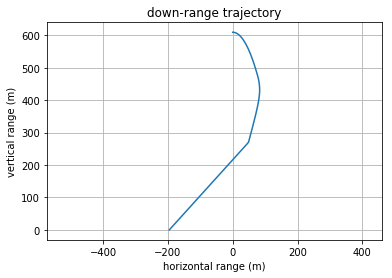

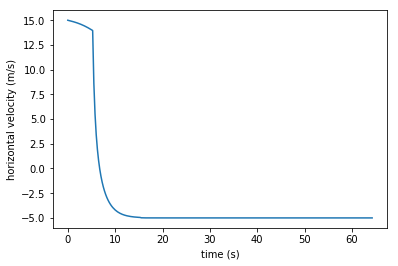

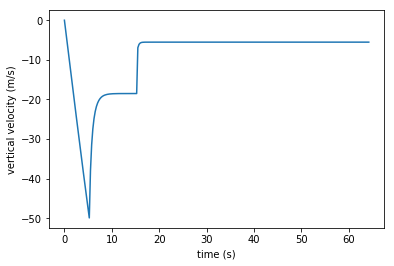

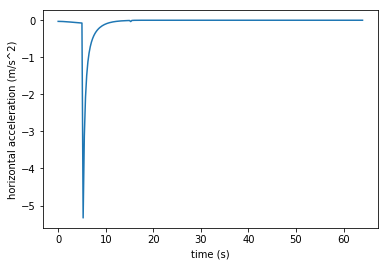

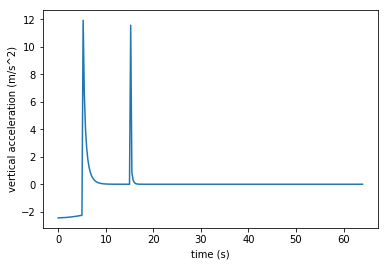

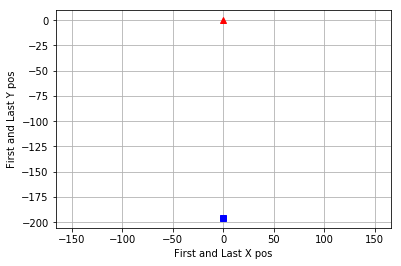

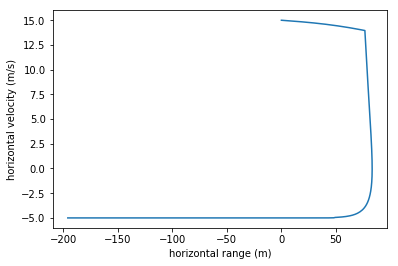

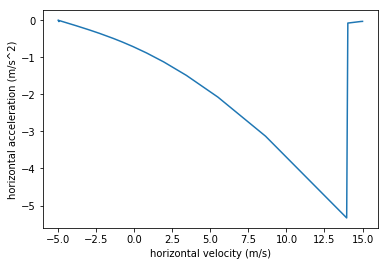

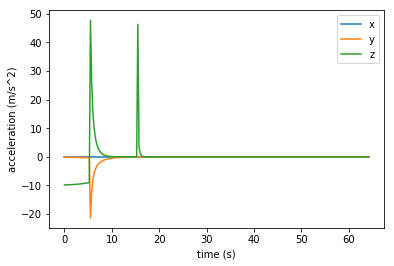

In [7]:
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory(v_plane=15, v_wind=5, dt=0.25, prnt=True)

    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)


No Failures detected!

Static Line Taut!

Drogue Deployed!

Drogue Line Taut!

Drogue Actively Dragging!

Main Chute Dragging!

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 210.03 m = 689.08 ft
TOTAL VERTICAL DISTANCE DESCENDED: 609.6 m = 2000.0 ft
TOTAL TIME FOR DESCENT: 66.65 s = 1.11 min
Final coordinates: (x, y) = ( -3.704095189056466e-14 , -210.03096892435468 )


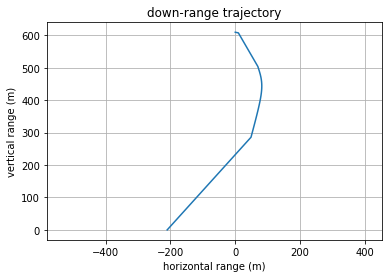

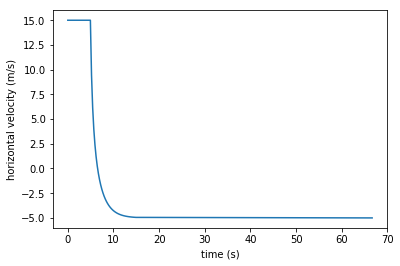

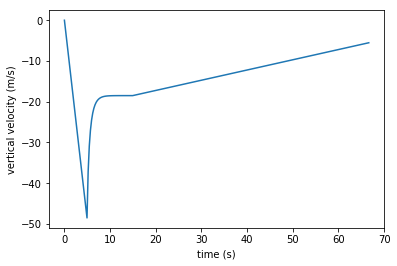

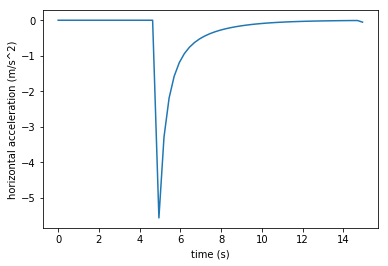

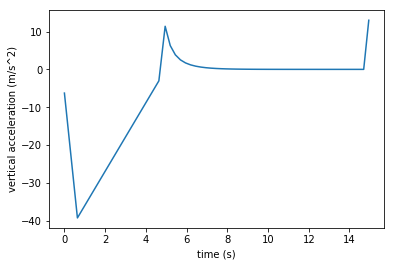

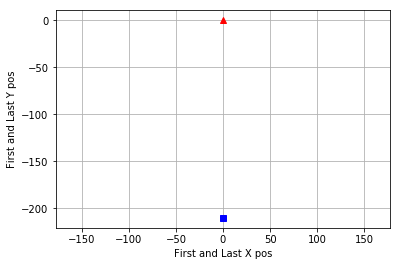

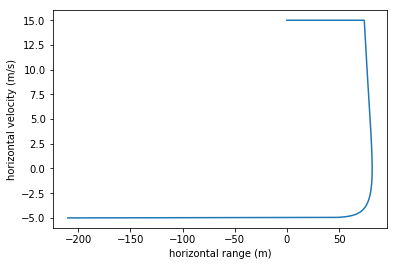

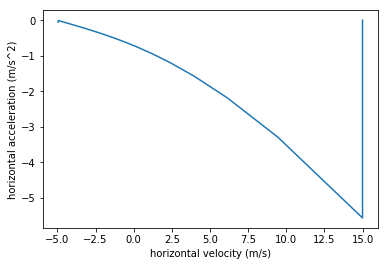

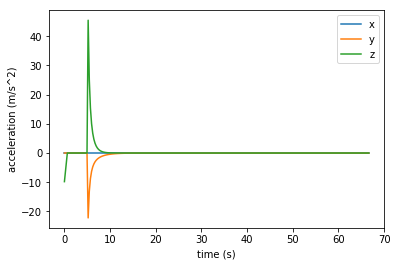

In [8]:
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory_fast(v_plane=15, v_wind=5, dt=0.25, prnt=True)

    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)

As we can see, we lose a small amount of accuracy by using a larger timestep, but if we use that same larger time step for the drogue descent phase and use our one step linear approximations for each other phase, that accuracy seems to be regained.

This is likely because the steady state during the main chute descent phase dominates the simulation and is simply the wind velocity and terminal velocity, and both are constants. This justifies our use of trajectory_fast() in the Monte Carlo simulation. If you are both nervous and patient, you are free to use trajectory() for that instead but it is likely unimportant.


# Failure Modes
Now we will investigate our failure modes. The cases are A (no main chute), B (no drogue), C (no drogue and early main deployment), and D (total dud). Note that a blank case will represent mission success. Also note that we are still ignoring drag from the body of the recovery system. I would prefer to account for it, but I have yet to estimate its coefficients. As such, there is no difference between case B and case D, since the main chute deploys after impact without a drogue to slow descent. Therefore, we will only check the success case, case A, case B, and case C in our Monte Carlo simulation.

I've checked the default wind/plane scenario and found that the variance between smooth and rough trajectories seems negligible for our failure modes as well. You are free to double check yourself, it only requires changing which trajectory function you run. I ran the smooth trajectory here because the graphs from trajectory_fast() are uninsightful.

Recovery system is a dud! Now Im freee. Free fallin!

Static Line Taut!

Drogue Deployed!

Drogue Line Taut!

Drogue Actively Dragging!

Main Chute Actively Dragging!

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 156.47 m = 513.35 ft
TOTAL VERTICAL DISTANCE DESCENDED: 609.7 m = 2000.34 ft
TOTAL TIME FOR DESCENT: 11.53 s = 0.19 min
Final coordinates: (x, y) = ( -5.023026881998155e-16 , 156.46854914251045 )


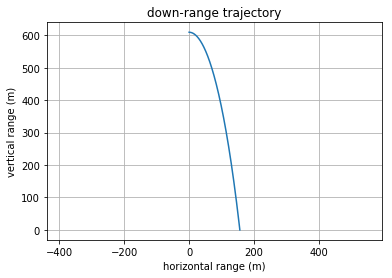

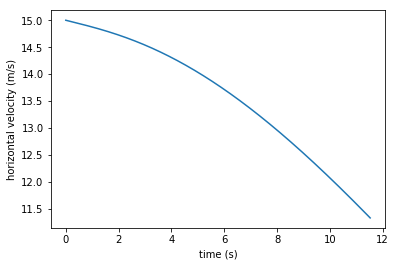

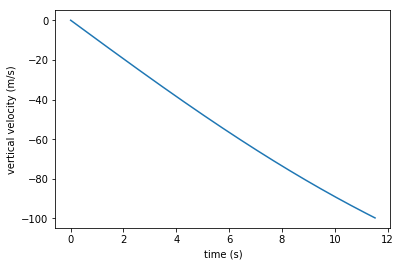

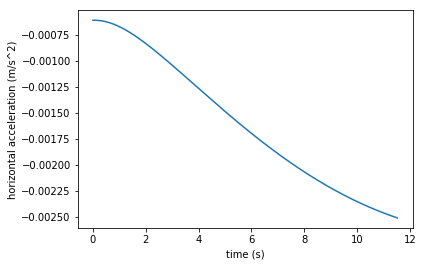

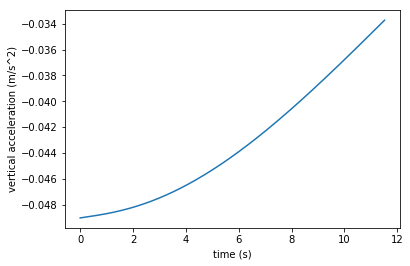

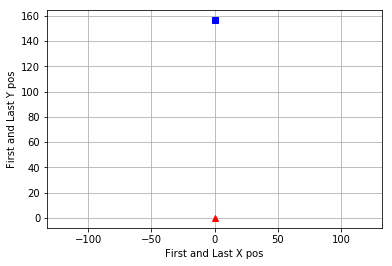

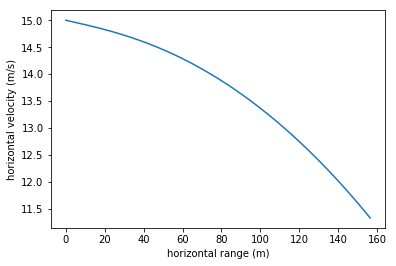

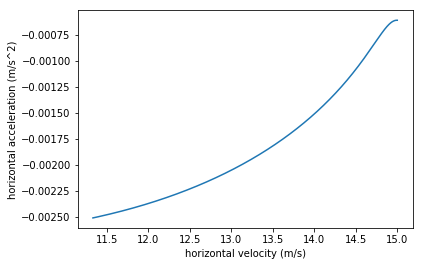

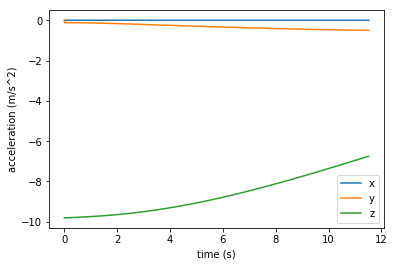

In [17]:
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory(v_plane=15, v_wind=5, mode='D', dt=0.005, prnt=True)

    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)

Drogue Failure!

Static Line Taut!

Drogue Deployed!

Drogue Line Taut!

Drogue Actively Dragging!

Main Chute Actively Dragging!

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 156.47 m = 513.35 ft
TOTAL VERTICAL DISTANCE DESCENDED: 609.7 m = 2000.34 ft
TOTAL TIME FOR DESCENT: 11.53 s = 0.19 min
Final coordinates: (x, y) = ( -5.023026881998155e-16 , 156.46854914251045 )


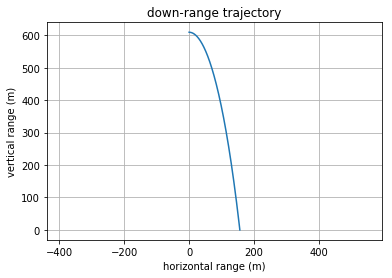

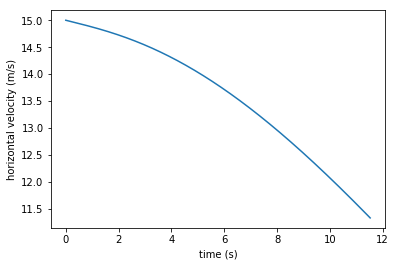

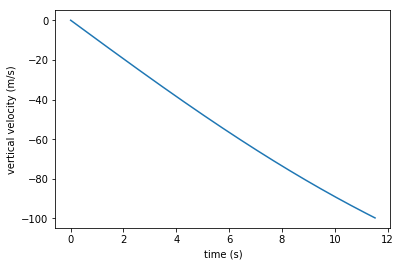

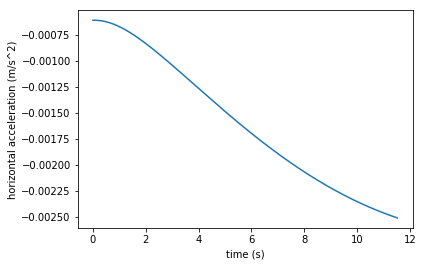

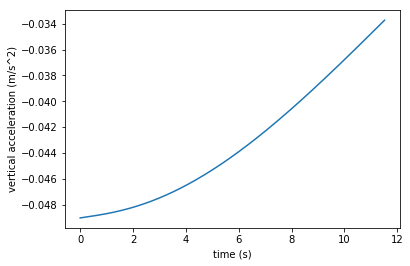

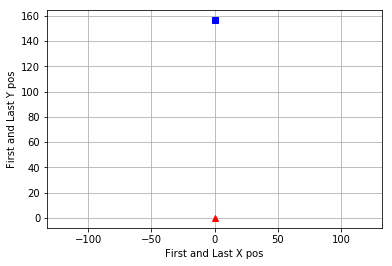

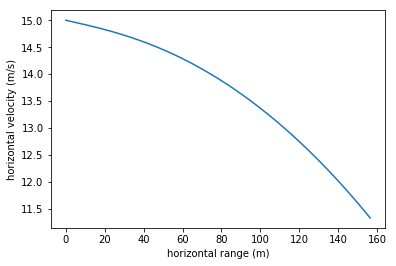

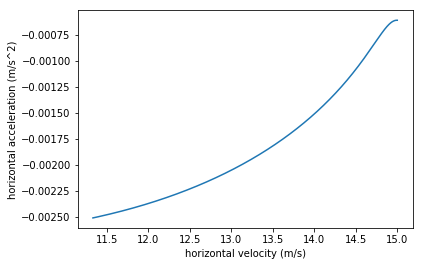

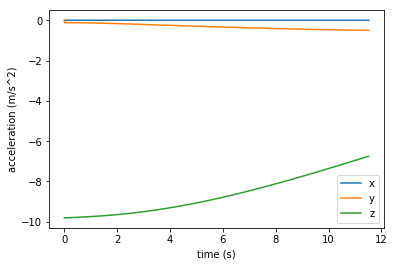

In [18]:
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory(v_plane=15, v_wind=5, mode='B', dt=0.005, prnt=True)

    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)

Main Chute Failure!

Static Line Taut!

Drogue Deployed!

Drogue Line Taut!

Drogue Actively Dragging!

Main Chute Actively Dragging!

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 31.62 m = 103.75 ft
TOTAL VERTICAL DISTANCE DESCENDED: 609.66 m = 2000.2 ft
TOTAL TIME FOR DESCENT: 30.5 s = 0.51 min
Final coordinates: (x, y) = ( -1.4975053641825235e-14 , -31.622370703176564 )


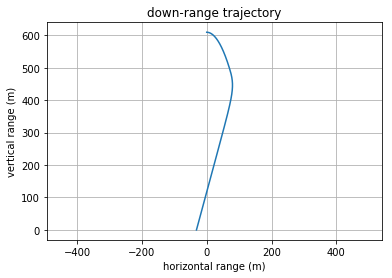

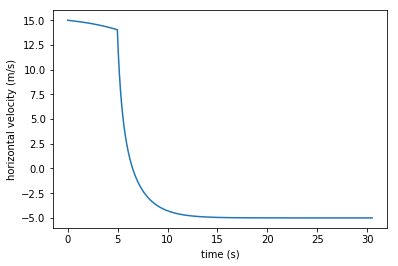

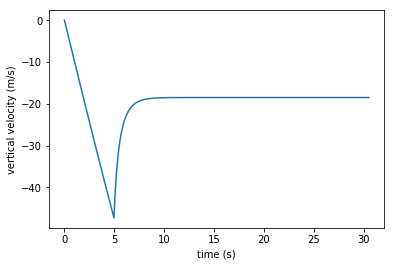

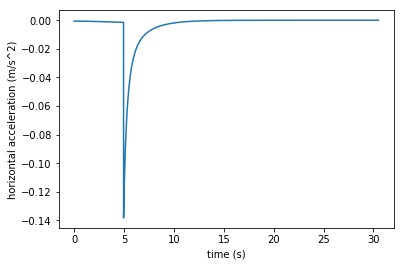

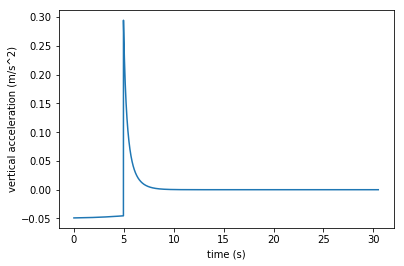

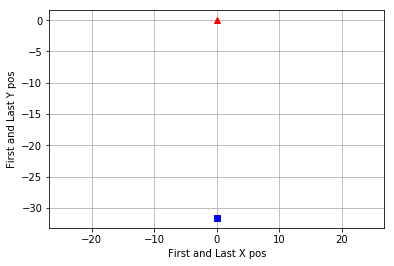

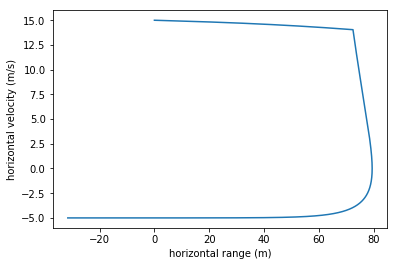

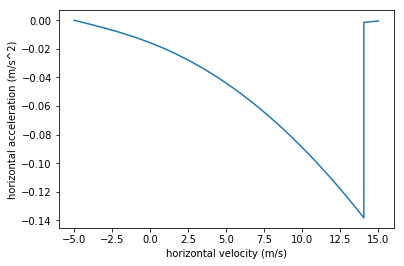

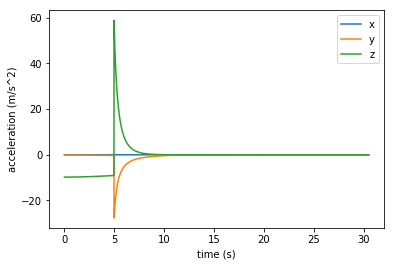

In [19]:
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory(v_plane=15, v_wind=5, mode='A', dt=0.005, prnt=True)

    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)

Drogue Failure and Early Main Chute Deployment!

Static Line Taut!

Drogue Deployed!

Main Chute Actively Dragging!

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 381.73 m = 1252.38 ft
TOTAL VERTICAL DISTANCE DESCENDED: 609.61 m = 2000.03 ft
TOTAL TIME FOR DESCENT: 95.3 s = 1.59 min
Final coordinates: (x, y) = ( -5.545279401050624e-14 , -381.72570357826754 )


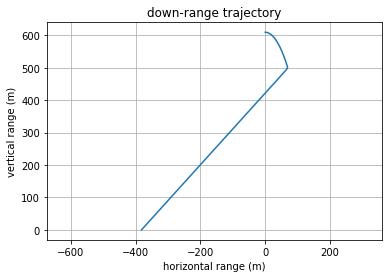

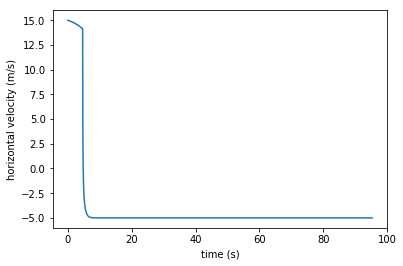

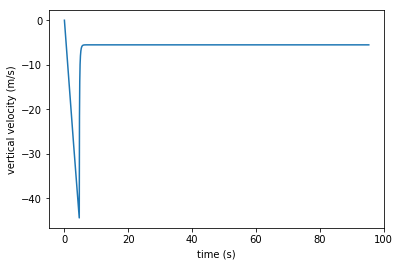

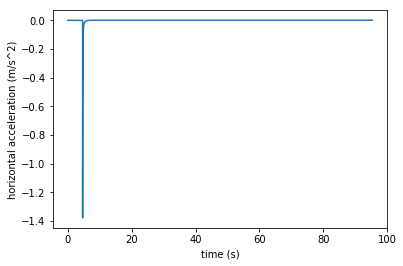

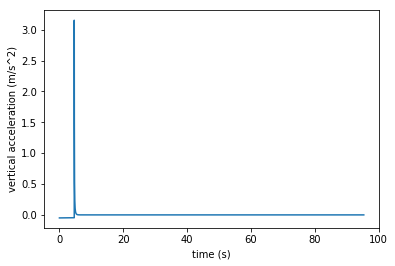

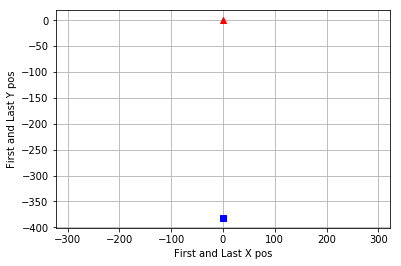

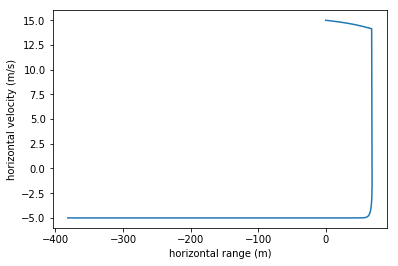

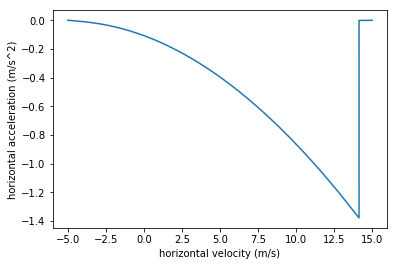

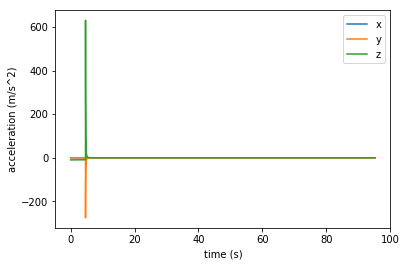

In [20]:
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory(v_plane=15, v_wind=5, mode='C', dt=0.005, prnt=True)

    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)